### First, we create a notebook with autoreload with appropriate imports

In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

In [2]:
from pathlib import Path
import shutil
import numpy as np

import spikeinterface.full as si
import probeinterface

In [3]:
#base_folder = Path("/home/samuel/DataSpikeSorting/WIRED_SI_tutos/")
base_folder = Path("/home/pierre/WIRED_SI_tutos/")

### We set the number of jobs globally for spikeinterface

In [4]:
si.set_global_job_kwargs(n_jobs=-1, chunk_duration="1s", progress_bar=True)

### Then we focus on a particular dataset

In [5]:
probe_type = "AdTech"
subject_id = "sub-001"
session_id = "sess-001"

In [6]:
neuralynx_folder = base_folder / "Neuralynx" / probe_type / subject_id / session_id / "ieeg"
print(neuralynx_folder)

binary_folder = base_folder / "Binary" / probe_type / subject_id / session_id / "ieeg"
binary_folder.parent.mkdir(exist_ok=True, parents=True)
print(binary_folder)

(base_folder / "sortings").mkdir(exist_ok=True, parents=True)

/home/pierre/WIRED_SI_tutos/Neuralynx/AdTech/sub-001/sess-001/ieeg
/home/pierre/WIRED_SI_tutos/Binary/AdTech/sub-001/sess-001/ieeg


### We can load the data from neuralynx format and save it to binary

In [7]:
if binary_folder.exists():
    # already converted
    raw_recording =si.load_extractor(binary_folder)
else:
    raw_recording = si.read_neuralynx(neuralynx_folder)
    print(raw_recording)
    #raw_recording = si.concatenate_recordings([raw_recording])
    print(raw_recording)
    raw_recording = raw_recording.save(folder=binary_folder)

In [8]:
print(raw_recording)

BinaryFolderRecording: 8 channels - 32.8kHz - 1 segments - 235,929,740 samples 
                       7,200.00s (2.00 hours) - int16 dtype - 3.52 GiB


### We need to create the probes, and attach them to the recordings

With the DIXI probe, we have no insight on the positions of the channels. Therefore, we will make them artificially far from each other in order to ensure that they are processed independantly. This is a choice that has to be taken. Either you set the channels far apart from each others (xpitch, ypitch very large), either you let the sorting algorithm decide, and set them close alltogether, assuming you do not really know the physical positions

In [41]:
probe = probeinterface.generate_multi_columns_probe(num_columns=2, num_contact_per_column=4, xpitch=200, ypitch=200)
probe.set_device_channel_indices(np.arange(raw_recording.get_num_channels()))
probe

Probe - 8ch - 1shanks

In [42]:
probe.to_dataframe()

,x,y,contact_shapes,radius,shank_ids,contact_ids
0,0.0,0.0,circle,6.0,,0
1,0.0,200.0,circle,6.0,,1
2,0.0,400.0,circle,6.0,,2
3,0.0,600.0,circle,6.0,,3
4,200.0,0.0,circle,6.0,,4
5,200.0,200.0,circle,6.0,,5
6,200.0,400.0,circle,6.0,,6
7,200.0,600.0,circle,6.0,,7


In [43]:
raw_recording = raw_recording.set_probe(probe)
print(raw_recording)

FrameSliceRecording: 8 channels - 32.8kHz - 1 segments - 58,982,400 samples 
                     1,800.00s (30.00 minutes) - int16 dtype - 900.00 MiB


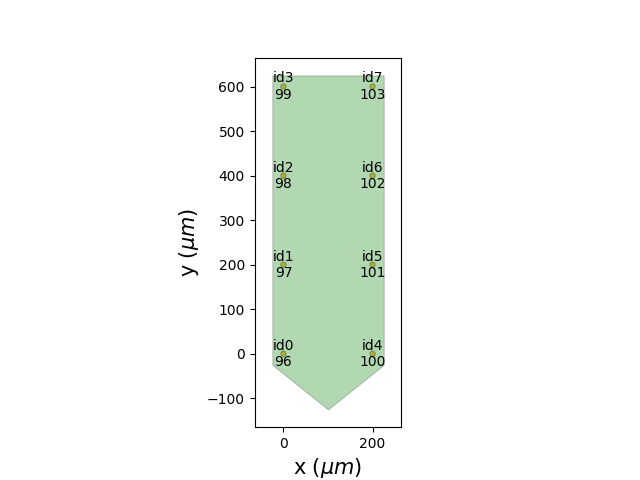

In [44]:
si.plot_probe_map(raw_recording, with_channel_ids=True, with_contact_id=True)

### Slicing the recording (for the demo only)

In [45]:
frame_start = 0
frame_stop = int(30 * 60 * raw_recording.sampling_frequency)
raw_recording = raw_recording.frame_slice(frame_start, frame_stop)

## explore raw traces

two way:
  * inside jupyter with `backend="ipywidgets"` : slow but enable remote visualization
  * using desktop app `backend="ephyviewer"` (no remote vis) : faster but freeze the jupyter notebook


In [14]:
%matplotlib widget
si.plot_traces(raw_recording, backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [15]:
# this work only with local notebook!!!
%gui qt
si.plot_traces(raw_recording, backend="ephyviewer")

### We can preprocess the signals, and also extract an enveloppe to remove/identify artefacts

In [16]:
recording_f = si.bandpass_filter(raw_recording, freq_min=300.0, freq_max=8000.0, dtype='float32')
recording_preprocess = si.common_reference(recording_f)
recording_preprocess

CommonReferenceRecording: 8 channels - 32.8kHz - 1 segments - 58,982,400 samples 
                          1,800.00s (30.00 minutes) - float32 dtype - 1.76 GiB

In [17]:
%matplotlib widget
si.plot_traces({"preprocess": recording_preprocess, "filtered_only":recording_f} , backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

In [18]:
%gui qt
si.plot_traces(recording_preprocess, backend="ephyviewer")

## detect and remove artifact

The preprocess signal show very high artifact.

Here a simple way to handle then:
  * create the signal envelop
  * detect period with high
  * blank period with zeros or noise


In [19]:
from threshold_detector import detect_artefacts
## Get the enveloppe
enveloppe = si.rectify(recording_preprocess)
enveloppe = si.gaussian_filter(enveloppe, freq_min=None, freq_max=20.)
enveloppe = si.common_reference(enveloppe)
print(enveloppe)

periods = detect_artefacts(enveloppe, detect_threshold=5)
print("Artefact period", len(periods))

CommonReferenceRecording: 8 channels - 32.8kHz - 1 segments - 58,982,400 samples 
                          1,800.00s (30.00 minutes) - float32 dtype - 1.76 GiB


detecting threshold crossings:   0%|          | 0/1800 [00:00<?, ?it/s]

Artefact period 1183


In [20]:
recording_silenced = si.silence_periods(recording_preprocess, periods, mode='zeros')
# recording_silenced = si.silence_periods(recording_preprocess, periods, mode='noise')
recording_silenced

SilencedPeriodsRecording: 8 channels - 32.8kHz - 1 segments - 58,982,400 samples 
                          1,800.00s (30.00 minutes) - float32 dtype - 1.76 GiB

In [21]:
%matplotlib widget
si.plot_traces({"silenced": recording_silenced, "with_artifact":recording_preprocess, "enveloppe" :enveloppe} , backend="ipywidgets")

AppLayout(children=(TimeSlider(children=(Dropdown(description='segment', options=(0,), value=0), Button(icon='…

## Noise levels over time, before and after cleaning

We can check that removing the artefacts is indeed reducing the noise levels, as expected. We can also appreciate the dispersion of the noise over all channels, and see that the MAD tends to be less variable than the STD, with a ratio of approx 0.66


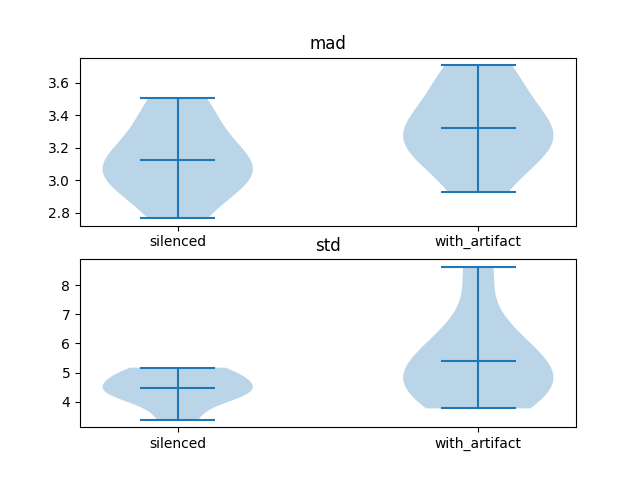

In [22]:
noise_levels = {}
my_dict = {"silenced": recording_silenced, "with_artifact":recording_preprocess}
for key, rec in my_dict.items():
    noise_levels[key] = {}
    for method in ['std', 'mad']:
        noise = si.get_noise_levels(rec, return_scaled=True, num_chunks_per_segment=100, 
                                    force_recompute=True, concatenated=True, method=method)
        noise_levels[key][method] = noise

import pylab as plt
fig, axes = plt.subplots(2, 1)
for count, key in enumerate(['mad', 'std']):
    axes[count].violinplot([noise_levels[r][key] for r in my_dict.keys()], showmeans=True)
    axes[count].set_title(key)
    axes[count].set_xticks([1, 2], ['silenced', 'with_artifact'])

In [23]:
%gui qt
si.plot_traces({"silenced": recording_silenced, "with_artifact":recording_preprocess}, backend='ephyviewer')

In [24]:
recording = recording_silenced

### Let's launch a very simple and naive sorter on the data (peak detection, feature extraction, clustering)

In [46]:
sorter_name = 'simple'
output_folder = base_folder / "sortings" / f"{probe_type} {subject_id} {session_id} {sorter_name}"
print(output_folder)
if output_folder.exists():
    shutil.rmtree(output_folder)

sorting = si.run_sorter(sorter_name, recording, verbose=True, 
                          output_folder=output_folder,
                          apply_preprocessing=False,
                          detection= {"peak_sign": "neg",  "detect_threshold": 10.0, "radius_um": 150.},
                          # clustering={"method" : "hdbscan", "num_spikes_to_fit" : 50000},
                          clustering={"method" : "kmeans", "n_init" : "auto", "n_clusters": 16},
                          # clustering={"method" : "mean_shift"},
                          )
sorting

/home/pierre/WIRED_SI_tutos/sortings/AdTech sub-001 sess-001 simple
detect peaks using locally_exclusive with n_jobs = 20 and chunk_size = 32768


detect peaks using locally_exclusive:   0%|          | 0/1800 [00:00<?, ?it/s]

We found 85375 peaks in total
extract waveforms shared_memory mono buffer with n_jobs = 20 and chunk_size = 32768


extract waveforms shared_memory mono buffer:   0%|          | 0/1800 [00:00<?, ?it/s]

extracting features with n_jobs = 20 and chunk_size = 32768


extracting features:   0%|          | 0/1800 [00:00<?, ?it/s]

simple run time 18.31s


NumpyFolderSorting: 16 units - 1 segments - 32.8kHz

### We can explore the features that have been found, with the assigned labels

In [47]:
features = np.load(output_folder / "sorter_output" / "features" / "features_tsvd.npy")
features_flat = features.reshape(len(features), -1)
labels = np.load(output_folder / "sorter_output" / "features" / "peak_labels.npy")
print(features.shape, features_flat.shape, labels.shape)

(85375, 3, 8) (85375, 24) (85375,)


### We can do a 2D projections from a High Dimensional space with UMAP

In [48]:
import umap
mapper = umap.UMAP().fit(features_flat[::100])

<Axes: >

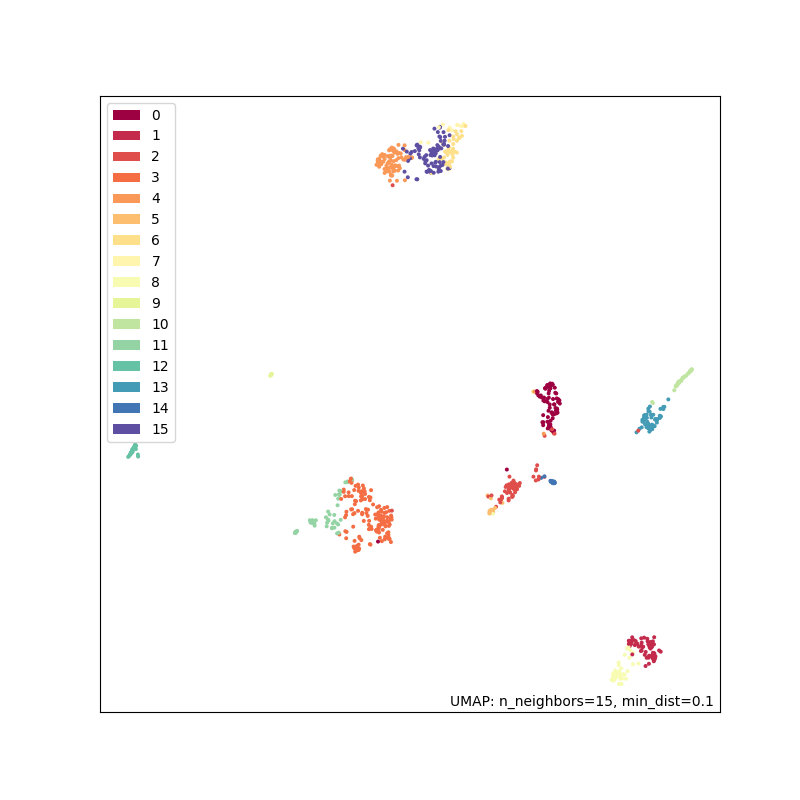

In [49]:
import umap.plot
umap.plot.points(mapper, labels=labels[::100])

## Run SortingAnalzer

In [50]:
analyzer = si.create_sorting_analyzer(sorting, recording_preprocess, format="memory")
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels",
                  "spike_amplitudes", "template_similarity"])
analyzer.compute("unit_locations", method="monopolar_triangulation")
analyzer.compute("correlograms", window_ms=50., bin_ms=1.)
analyzer.compute("principal_components", n_components=3, mode='by_channel_global', whiten=True)
analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate", "rp_violation"])
print(analyzer)


estimate_sparsity:   0%|          | 0/1800 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/1800 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/1800 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/16 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/16 [00:00<?, ?it/s]

SortingAnalyzer: 8 channels - 16 units - 1 segments - memory - sparse - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, template_similarity, unit_locations, correlograms, principal_components, quality_metrics


In [51]:
anlyzer_folder = base_folder / "sortings" / f"Analyzer {probe_type} {subject_id} {session_id} {sorter_name}"
if anlyzer_folder.exists():
    shutil.rmtree(anlyzer_folder)
analyzer = analyzer.save_as(format="binary_folder", folder=anlyzer_folder)
print(analyzer)

SortingAnalyzer: 8 channels - 16 units - 1 segments - binary_folder - sparse - has recording
Loaded 10 extenstions: random_spikes, waveforms, templates, noise_levels, spike_amplitudes, template_similarity, unit_locations, correlograms, principal_components, quality_metrics


In [38]:
%gui qt
si.plot_sorting_summary(analyzer, backend='spikeinterface_gui')

### Let's see if there are obvious merges in the results

In [52]:
si.get_potential_auto_merge(analyzer)

[]

### Let's launch more advanced sorters using template mathcing : spykingcircus2

In [53]:
sorter_name = 'spykingcircus2'
output_folder = base_folder / "sortings" / f"{probe_type} {subject_id} {session_id} {sorter_name}"
print(output_folder)

if output_folder.exists():
    shutil.rmtree(output_folder)

sorting = si.run_sorter(sorter_name, recording, verbose=True, 
                          output_folder=output_folder,
                          apply_preprocessing=False, 
                          detection= {"peak_sign": "neg",  "detect_threshold": 5.0},
                          )
sorting

/home/pierre/WIRED_SI_tutos/sortings/AdTech sub-001 sess-001 spykingcircus2
detect peaks using locally_exclusive with n_jobs = 16 and chunk_size = 32768


detect peaks using locally_exclusive:   0%|          | 0/1800 [00:00<?, ?it/s]

We found 198216 peaks in total
We kept 100000 peaks for clustering
extracting features with n_jobs = 16 and chunk_size = 32768


extracting features:   0%|          | 0/1800 [00:00<?, ?it/s]

estimate_templates with n_jobs = 16 and chunk_size = 32768


estimate_templates:   0%|          | 0/1800 [00:00<?, ?it/s]

/home/pierre/github/spikeinterface/src/spikeinterface/core/baserecordingsnippets.py:244: UserWarning: There is no Probe attached to this recording. Creating a dummy one with contact positions
  warn("There is no Probe attached to this recording. Creating a dummy one with contact positions")


We found 19 raw clusters, starting to clean with matching...
We kept 19 non-duplicated clusters...
estimate_templates with n_jobs = 16 and chunk_size = 32768


estimate_templates:   0%|          | 0/1800 [00:00<?, ?it/s]

find spikes (circus-omp-svd) with n_jobs = 16 and chunk_size = 3276


find spikes (circus-omp-svd):   0%|          | 0/18005 [00:00<?, ?it/s]

We found 191939 spikes
spykingcircus2 run time 122.58s


NumpyFolderSorting: 19 units - 1 segments - 32.8kHz

In [35]:
analyzer = si.create_sorting_analyzer(sorting, recording, format="memory")
analyzer.compute(["random_spikes", "waveforms", "templates", "noise_levels",
                  "isi_histograms", "spike_amplitudes", "template_similarity"])
analyzer.compute("unit_locations", method="grid_convolution")
analyzer.compute("correlograms", window_ms=50., bin_ms=1.)
analyzer.compute("principal_components", n_components=3, mode='by_channel_global', whiten=True)
analyzer.compute("quality_metrics", metric_names=["snr", "firing_rate", "rp_violation"])
print(analyzer)

estimate_sparsity:   0%|          | 0/1800 [00:00<?, ?it/s]

compute_waveforms:   0%|          | 0/1800 [00:00<?, ?it/s]

spike_amplitudes:   0%|          | 0/1800 [00:00<?, ?it/s]

Fitting PCA:   0%|          | 0/20 [00:00<?, ?it/s]

Projecting waveforms:   0%|          | 0/20 [00:00<?, ?it/s]

SortingAnalyzer: 8 channels - 20 units - 1 segments - memory - sparse - has recording
Loaded 11 extenstions: random_spikes, waveforms, templates, noise_levels, isi_histograms, spike_amplitudes, template_similarity, unit_locations, correlograms, principal_components, quality_metrics


In [36]:
anlyzer_folder = base_folder / "sortings" / f"Analyzer {probe_type} {subject_id} {session_id} {sorter_name}"
if anlyzer_folder.exists():
    shutil.rmtree(anlyzer_folder)
analyzer = analyzer.save_as(format="binary_folder", folder=anlyzer_folder)
print(analyzer)

SortingAnalyzer: 8 channels - 20 units - 1 segments - binary_folder - sparse - has recording
Loaded 11 extenstions: random_spikes, waveforms, templates, noise_levels, isi_histograms, spike_amplitudes, template_similarity, unit_locations, correlograms, principal_components, quality_metrics


In [37]:
%gui qt
si.plot_sorting_summary(analyzer, backend='spikeinterface_gui')

### Let's see if there are obvious merges in the results

In [38]:
si.get_potential_auto_merge(analyzer)

[]

### Now, let's see how many units can pass the quality threehold

In [39]:
metrics = analyzer.get_extension('quality_metrics').get_data()
quality_criteria = 'snr > 3 & rp_contamination < 0.4'
good_unit_indices = metrics.query(quality_criteria)
print(good_unit_indices)

    firing_rate  rp_contamination  rp_violations      snr
14     5.768889          0.086632           10.0  5.84756


In [40]:
si.plot_sorting_summary(analyzer, backend='sortingview')

https://figurl.org/f?v=npm://@fi-sci/figurl-sortingview@12/dist&d=sha1://de66d5827bcf89c1979dd2440458152c8a863f90
